In [1]:
# import essential libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle
import joblib

In [2]:
# import library for normalizing, modeling, evaluate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, auc
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Prep

In [3]:
#Reading training and testing data as dataframes
full = pd.read_csv("Transaction.csv",sep =",")
account = pd.read_csv("Account.csv",sep =",")
product = pd.read_csv("Product.csv",sep =",")

In [4]:
full.describe()

,transaction_id,Account_id,transaction_amount,gas_price_purchase,product_id,Location
count,44500.000000,44500.000000,44500.000000,44500.000000,44500.000000,44500.0
mean,22250.500000,1698.967326,26.459262,24.931345,6.666157,7.0
std,12846.187826,543.420426,28.004480,27.375839,3.198977,0.0
min,1.000000,1001.000000,0.000000,0.000000,1.000000,7.0
25%,11125.750000,1251.000000,3.000000,0.000000,4.000000,7.0
50%,22250.500000,1512.000000,3.500000,0.000000,7.000000,7.0
75%,33375.250000,2096.000000,49.260000,49.320000,10.000000,7.0
max,44500.000000,3000.000000,881.090000,89.370000,10.000000,7.0


In [5]:
account

,Account_id,Age,Register Date,Unnamed: 3
0,1001,31.0,NaN,
1,1002,29.0,NaN,
2,1003,54.0,NaN,
3,1004,28.0,NaN,
4,1005,64.0,'2022-10-02',
...,...,...,...,...
1995,2996,NaN,NaN,NaN
1996,2997,NaN,NaN,NaN
1997,2998,NaN,NaN,NaN
1998,2999,NaN,NaN,NaN


In [6]:
account.drop(['Register Date','Unnamed: 3'],axis=1, inplace=True)
account.head()

,Account_id,Age
0,1001,31.0
1,1002,29.0
2,1003,54.0
3,1004,28.0
4,1005,64.0


In [7]:
account.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Account_id  2000 non-null   int64  
 1   Age         1373 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [8]:
avg_age = account['Age'].mean()
avg_age

40.86161689730517

In [9]:
account = account.fillna(avg_age)

In [10]:
account.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Account_id  2000 non-null   int64  
 1   Age         2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [11]:
account.set_index('Account_id')

,Age
Account_id,
1001,31.000000
1002,29.000000
1003,54.000000
1004,28.000000
1005,64.000000
...,...
2996,40.861617
2997,40.861617
2998,40.861617


In [12]:
account_dict = dict()
for i in range(len(account)):
    account_dict[account['Account_id'][i]] = account['Age'][i]

In [13]:
full.head()

,transaction_id,Account_id,transaction_amount,transaction_date,time_to_purchase,gas_type,gas_price_purchase,product_id,Location
0,23,1004,2.50,1/1/2023,19:00,NaN,0.00,1,7
1,41666,1013,65.77,1/1/2023,11:00,A,65.77,7,7
2,6321,1014,37.80,1/1/2023,12:00,B,37.80,10,7
3,34042,1015,3.00,1/1/2023,15:00,NaN,0.00,2,7
4,1006,1016,3.00,1/1/2023,16:00,NaN,0.00,2,7


In [14]:
# fill in new column
full.insert(0,'age',0)
full.insert(0,'product_price',0)
full.insert(0,'product_cat',0)
full.insert(0,'time',0)
full.insert(0,'day',0)
full.insert(0,'month',0)

l_product_cat = [0,1,0,1,1,0,0,0,0,0]
l_product_price = [2.5,3,2,3.5,3,3.5,3.5,2.5,3,4]

for i in range(len(full)):
    full['age'][i] = account_dict[full['Account_id'][i]]
    full["product_price"][i] = l_product_price[full["product_id"][i]-1]
    full["product_cat"][i] = l_product_cat[full["product_id"][i]-1]
    hour, minute = full['time_to_purchase'][i].split(':')
    full['time'][i] = int(hour)*60 + int(minute)
    month, day, year = full['transaction_date'][i].split('/')
    full['day'][i] = int(day)
    full['month'][i] = int(month)

C:\Users\user\AppData\Local\Temp\ipykernel_4496\2444927080.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full['age'][i] = account_dict[full['Account_id'][i]]
C:\Users\user\AppData\Local\Temp\ipykernel_4496\2444927080.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full["product_price"][i] = l_product_price[full["product_id"][i]-1]
C:\Users\user\AppData\Local\Temp\ipykernel_4496\2444927080.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [15]:
full

,month,day,time,product_cat,product_price,age,transaction_id,Account_id,transaction_amount,transaction_date,time_to_purchase,gas_type,gas_price_purchase,product_id,Location
0,1,1,1140,0,2.5,28.000000,23,1004,2.50,1/1/2023,19:00,NaN,0.00,1,7
1,1,1,660,0,3.5,49.000000,41666,1013,65.77,1/1/2023,11:00,A,65.77,7,7
2,1,1,720,0,4.0,19.000000,6321,1014,37.80,1/1/2023,12:00,B,37.80,10,7
3,1,1,900,1,3.0,39.000000,34042,1015,3.00,1/1/2023,15:00,NaN,0.00,2,7
4,1,1,960,1,3.0,23.000000,1006,1016,3.00,1/1/2023,16:00,NaN,0.00,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44495,4,30,1320,0,3.5,40.861617,30788,2933,3.50,4/30/2023,22:00,NaN,0.00,6,7
44496,4,30,1380,0,4.0,40.861617,32274,2936,61.02,4/30/2023,23:00,A,61.02,10,7
44497,4,30,1320,1,3.5,40.861617,30444,2957,3.50,4/30/2023,22:00,NaN,0.00,4,7
44498,4,30,1320,0,4.0,40.861617,32399,2978,32.69,4/30/2023,22:00,B,32.69,10,7


In [16]:
full_copy = pd.DataFrame(full)
full_copy

,month,day,time,product_cat,product_price,age,transaction_id,Account_id,transaction_amount,transaction_date,time_to_purchase,gas_type,gas_price_purchase,product_id,Location
0,1,1,1140,0,2.5,28.000000,23,1004,2.50,1/1/2023,19:00,NaN,0.00,1,7
1,1,1,660,0,3.5,49.000000,41666,1013,65.77,1/1/2023,11:00,A,65.77,7,7
2,1,1,720,0,4.0,19.000000,6321,1014,37.80,1/1/2023,12:00,B,37.80,10,7
3,1,1,900,1,3.0,39.000000,34042,1015,3.00,1/1/2023,15:00,NaN,0.00,2,7
4,1,1,960,1,3.0,23.000000,1006,1016,3.00,1/1/2023,16:00,NaN,0.00,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44495,4,30,1320,0,3.5,40.861617,30788,2933,3.50,4/30/2023,22:00,NaN,0.00,6,7
44496,4,30,1380,0,4.0,40.861617,32274,2936,61.02,4/30/2023,23:00,A,61.02,10,7
44497,4,30,1320,1,3.5,40.861617,30444,2957,3.50,4/30/2023,22:00,NaN,0.00,4,7
44498,4,30,1320,0,4.0,40.861617,32399,2978,32.69,4/30/2023,22:00,B,32.69,10,7


In [17]:
# eliminate errors
index_list = []
for i in range(len(full)):
    if abs(full['transaction_amount'][i] -full['product_price'][i] - full['gas_price_purchase'][i]) > 0.009:
        index_list.append(i)

len(index_list)

22155

In [18]:
full = full.drop(index=index_list)

In [19]:
full

,month,day,time,product_cat,product_price,age,transaction_id,Account_id,transaction_amount,transaction_date,time_to_purchase,gas_type,gas_price_purchase,product_id,Location
0,1,1,1140,0,2.5,28.000000,23,1004,2.5,1/1/2023,19:00,NaN,0.0,1,7
3,1,1,900,1,3.0,39.000000,34042,1015,3.0,1/1/2023,15:00,NaN,0.0,2,7
4,1,1,960,1,3.0,23.000000,1006,1016,3.0,1/1/2023,16:00,NaN,0.0,2,7
5,1,1,900,1,3.5,23.000000,2170,1016,3.5,1/1/2023,15:00,NaN,0.0,4,7
7,1,1,540,0,2.0,39.000000,1659,1030,2.0,1/1/2023,9:00,NaN,0.0,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44491,4,30,1320,1,3.5,40.861617,30472,2890,3.5,4/30/2023,22:00,NaN,0.0,4,7
44493,4,30,1380,0,2.0,40.861617,30276,2894,2.0,4/30/2023,23:00,NaN,0.0,3,7
44494,4,30,1320,0,3.5,40.861617,30944,2913,3.5,4/30/2023,22:00,NaN,0.0,7,7
44495,4,30,1320,0,3.5,40.861617,30788,2933,3.5,4/30/2023,22:00,NaN,0.0,6,7


In [20]:
# explore variable
for col in full.columns.values:
    print(f"{20 * '-'}\n{col} \n{20 * '-'}")
    print(full[col].value_counts(), '\n')

--------------------
month 
--------------------
1    5842
3    5836
4    5580
2    5087
Name: month, dtype: int64 

--------------------
day 
--------------------
27    805
24    786
16    778
19    776
9     775
17    772
28    769
12    769
5     768
21    762
22    755
8     747
3     746
10    745
11    745
26    741
23    741
15    739
14    733
2     721
1     718
6     716
4     710
18    709
25    707
13    706
20    704
7     697
29    584
30    529
31    392
Name: day, dtype: int64 

--------------------
time 
--------------------
420     2084
360     2057
480     2046
1140    1872
1200    1522
1080    1321
840     1100
720     1081
780     1040
900     1016
540     1012
660     1007
960     1005
600     1004
1020     982
1320     946
1380     623
1260     332
1110     295
Name: time, dtype: int64 

--------------------
product_cat 
--------------------
0    14669
1     7676
Name: product_cat, dtype: int64 

--------------------
product_price 
--------------------
3.5    769

In [21]:
# drop unrelated columns
# transaction_id: unrelated
# transaction_date: unrelated + unable to transform into numbers
# gas_type: unrelated + a lot of NaN
# Location: all 7
# time_to_purchase: replaced with the numerical time column
full.drop(['transaction_id','transaction_date','gas_type','Location','time_to_purchase'],axis=1, inplace=True)

In [22]:
full.head()

,month,day,time,product_cat,product_price,age,Account_id,transaction_amount,gas_price_purchase,product_id
0,1,1,1140,0,2.5,28.0,1004,2.5,0.0,1
3,1,1,900,1,3.0,39.0,1015,3.0,0.0,2
4,1,1,960,1,3.0,23.0,1016,3.0,0.0,2
5,1,1,900,1,3.5,23.0,1016,3.5,0.0,4
7,1,1,540,0,2.0,39.0,1030,2.0,0.0,3


# Description

time: time in minutes from 0 (00:00) to 1499 (23:59)

product_cat: integer coded boolean (0 or 1) 0 for beverage 1 for pastry

product_price: price of product

age: the age of a customer, if none was recorded ana verage value is filled in 40.861617

Account_id: the account id (included as teh same person might order the same thing)

transaction_amount: total money spent

gas_price_purchase: the gas price (included just in case rich people buy different compared to poor)

product_id: categorical id of the product included instead of name

In [23]:
full.isnull().sum()

month                 0
day                   0
time                  0
product_cat           0
product_price         0
age                   0
Account_id            0
transaction_amount    0
gas_price_purchase    0
product_id            0
dtype: int64

In [24]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22345 entries, 0 to 44497
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   month               22345 non-null  int64  
 1   day                 22345 non-null  int64  
 2   time                22345 non-null  int64  
 3   product_cat         22345 non-null  int64  
 4   product_price       22345 non-null  float64
 5   age                 22345 non-null  float64
 6   Account_id          22345 non-null  int64  
 7   transaction_amount  22345 non-null  float64
 8   gas_price_purchase  22345 non-null  float64
 9   product_id          22345 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 1.9 MB


In [25]:
print("full", full.duplicated().sum())
# nothing to worry about, it is just the same customer ordering the same thing twice
# with the transcation_id this disappear

full 8


In [26]:
full.describe()

,month,day,time,product_cat,product_price,age,Account_id,transaction_amount,gas_price_purchase,product_id
count,22345.000000,22345.000000,22345.000000,22345.000000,22345.000000,22345.000000,22345.000000,22345.000000,22345.0,22345.00000
mean,2.499172,15.638622,807.658537,0.343522,2.942090,41.110518,1699.428105,2.942090,0.0,4.86968
std,1.128002,8.690667,317.727938,0.474894,0.505323,12.709702,541.972754,0.505323,0.0,2.52230
min,1.000000,1.000000,360.000000,0.000000,2.000000,7.000000,1001.000000,2.000000,0.0,1.00000
25%,1.000000,8.000000,480.000000,0.000000,2.500000,31.000000,1250.000000,2.500000,0.0,3.00000
50%,3.000000,16.000000,780.000000,0.000000,3.000000,40.861617,1519.000000,3.000000,0.0,5.00000
75%,3.000000,23.000000,1110.000000,1.000000,3.500000,51.000000,2094.000000,3.500000,0.0,7.00000
max,4.000000,31.000000,1380.000000,1.000000,3.500000,89.000000,3000.000000,3.500000,0.0,9.00000


In [27]:
full

,month,day,time,product_cat,product_price,age,Account_id,transaction_amount,gas_price_purchase,product_id
0,1,1,1140,0,2.5,28.000000,1004,2.5,0.0,1
3,1,1,900,1,3.0,39.000000,1015,3.0,0.0,2
4,1,1,960,1,3.0,23.000000,1016,3.0,0.0,2
5,1,1,900,1,3.5,23.000000,1016,3.5,0.0,4
7,1,1,540,0,2.0,39.000000,1030,2.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...
44491,4,30,1320,1,3.5,40.861617,2890,3.5,0.0,4
44493,4,30,1380,0,2.0,40.861617,2894,2.0,0.0,3
44494,4,30,1320,0,3.5,40.861617,2913,3.5,0.0,7
44495,4,30,1320,0,3.5,40.861617,2933,3.5,0.0,6


# **EDA**

### There are two data types:

**Numerical Data:** 
- product_price: price of product
- transaction_amount: total money spent
- gas_price_purchase: the gas price (included just in case rich people buy different compared to poor)
- age: the age of a customer, if none was recorded an average value is filled in 40.861617

**Categorical Data:**
- Account_id: the account id (included as teh same person might order the same thing)
- product_cat: integer coded boolean (0 or 1) 0 for beverage 1 for pastry
- product_id: categorical id of the product included instead of name

# Univariate Analysis

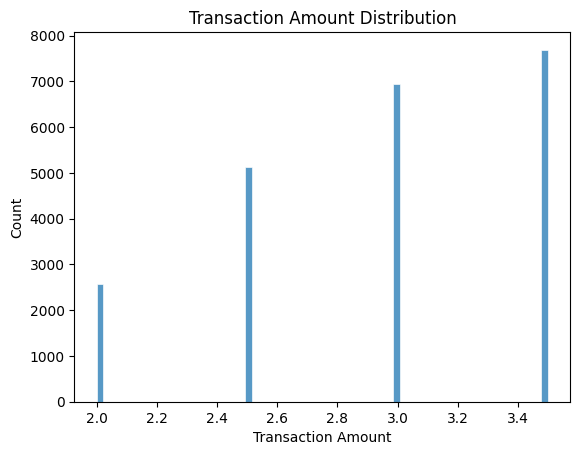

In [28]:
sns.histplot(data= full, x='transaction_amount', bins=70, edgecolor='white')
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Count')

plt.show()

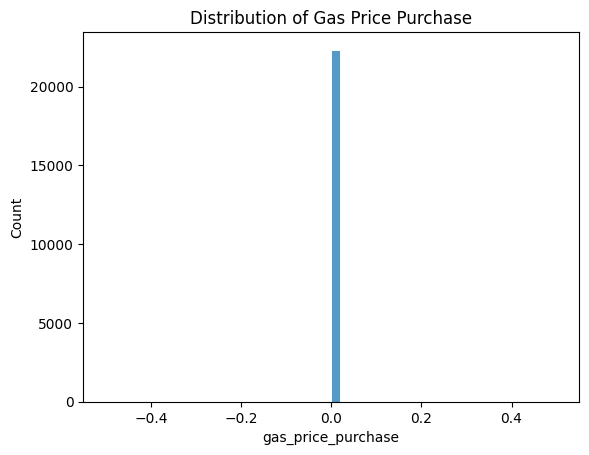

In [29]:
sns.histplot(data=full, x='gas_price_purchase', bins=50, edgecolor='white')
plt.title('Distribution of Gas Price Purchase')
plt.show()

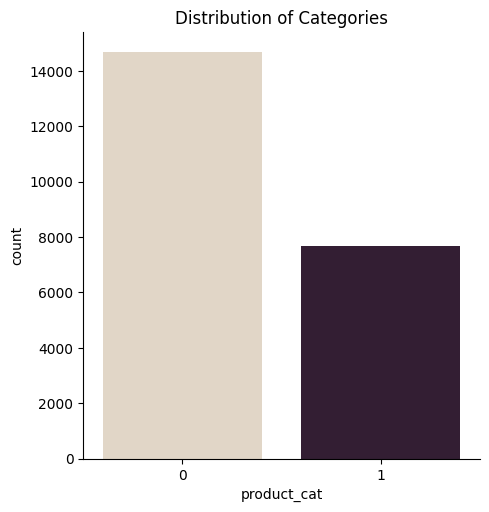

In [30]:
sns.catplot(data=full, x= 'product_cat', kind="count", palette="ch:.25")
plt.title('Distribution of Categories')
plt.show()
# beverage > pastry

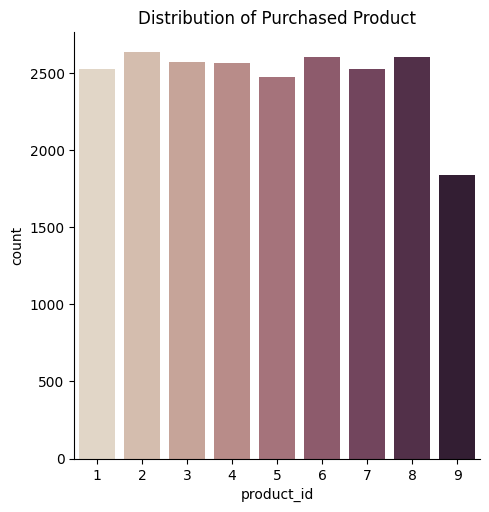

In [31]:
sns.catplot(data=full, x= 'product_id', kind="count", palette="ch:.25")
plt.title('Distribution of Purchased Product')
plt.show()

# 10 = redbull (highest) , 9 = hot chocolate (lowest)

# Bivariate Analysis

In [32]:
def plot_categorical_variable(data, name, figsize=(8,4), rotation=45):
    plt.figure(figsize=figsize)
    sns.set_theme(style="whitegrid")
    sns.countplot(x=data[name], data=data, hue='product_id')
    # plt.title(name)
    plt.xticks(rotation=rotation)
    plt.show()

    plt.figure(figsize=figsize)
    sns.set_theme(style="whitegrid")
    sns.countplot(x=data[name], data=data)
    # plt.title(name)
    plt.xticks(rotation=rotation)
    plt.show()

*Numerical Data  bar charts*



C:\Users\user\AppData\Local\Temp\ipykernel_4496\1088531251.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_products = merged.groupby(['product_id', 'product_name']).sum().sort_values(by='transaction_amount', ascending=False).head(10)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Latte'),
  Text(1, 0, 'Muffin'),
  Text(2, 0, 'Cappuccino'),
  Text(3, 0, 'Croissant'),
  Text(4, 0, 'Bagel'),
  Text(5, 0, 'Espresso'),
  Text(6, 0, 'Coffee'),
  Text(7, 0, 'Hot Chocolate'),
  Text(8, 0, 'Tea')])

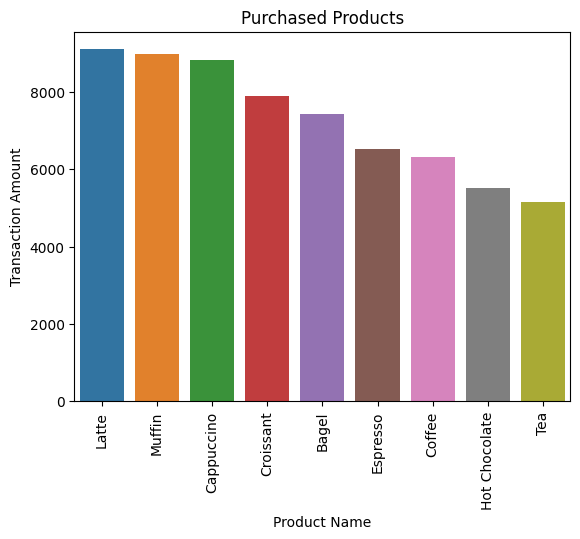

In [33]:
# transaction & purchased product barplot
merged = pd.merge(full, product, on='product_id')
top_products = merged.groupby(['product_id', 'product_name']).sum().sort_values(by='transaction_amount', ascending=False).head(10)
sns.barplot(data=top_products, x=top_products.index.get_level_values('product_name'), y='transaction_amount')
plt.title('Purchased Products')
plt.xlabel('Product Name')
plt.ylabel('Transaction Amount')
plt.xticks(rotation=90)

In [34]:
def get_age_group(age):
    if age < 10:
        return '0s'
    elif age < 20:
        return '10s'
    elif age < 30:
        return '20s'
    elif age < 40:
        return '30s'
    elif age < 50:
        return '40s'
    elif age < 60:
        return '50s'
    elif age < 70:
        return '60s'
    elif age < 80:
        return '70s'
    elif age < 90:
        return '80s'
    else:
        return '90+'

full['age_group'] = full['age'].apply(get_age_group)

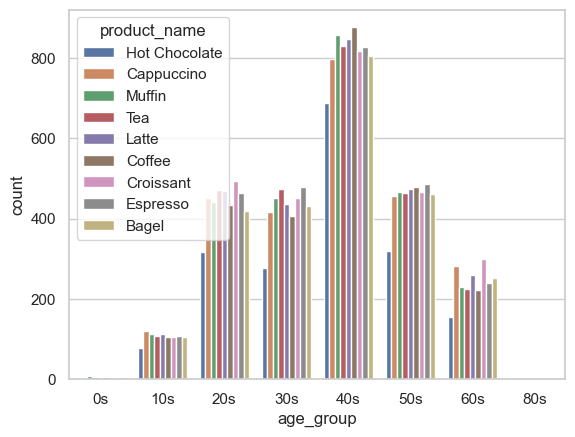

In [35]:
#age group & purchased product

merged_data = full.merge(product, on='product_id', how='left')
merged_data_sorted = merged_data.sort_values('age_group')
sns.set_theme(style="whitegrid")
sns.countplot(x='age_group', data= merged_data_sorted, hue='product_name')
plt.show()

# 40s redbull >>>>

Merged Dataset Summary:
       month  day  time  product_cat  product_price_x   age  Account_id  \
14873      3   22   360            1              3.5  33.0        1219   
14721      3   21   360            0              3.5  36.0        1483   
14720      3   21   360            1              3.0  48.0        1481   
14717      3   21   360            1              3.0  58.0        1456   
14712      3   21   360            1              3.0  63.0        1431   

       transaction_amount  gas_price_purchase  product_id age_group  \
14873                 3.5                 0.0           4       30s   
14721                 3.5                 0.0           7       30s   
14720                 3.0                 0.0           5       40s   
14717                 3.0                 0.0           2       50s   
14712                 3.0                 0.0           2       60s   

      product_name              product_description product_category  \
14873       Muffin        

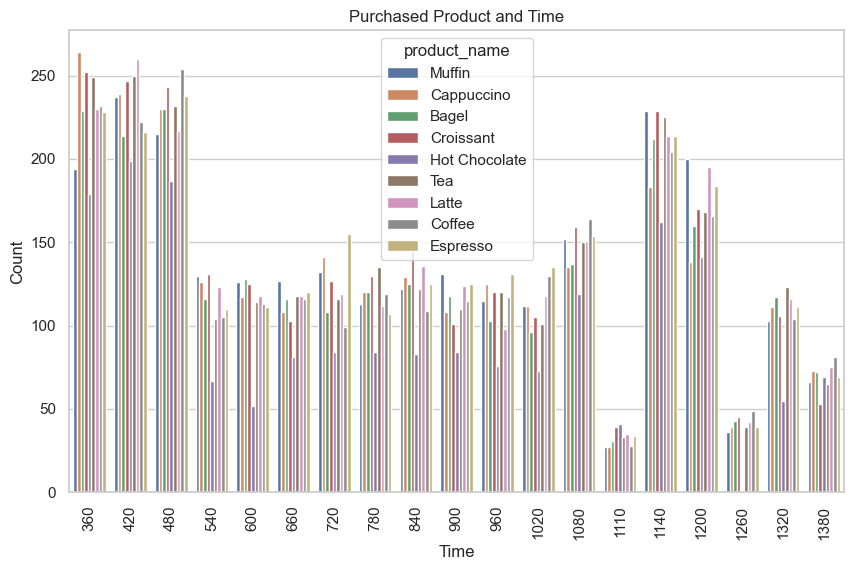

In [36]:
# time & product

# Perform the join operation
merged_data = full.merge(product, on='product_id', how='left')

# Sort the DataFrame by time
merged_data_sorted = merged_data.sort_values('time')

# Perform basic EDA
print("Merged Dataset Summary:")
print(merged_data_sorted.head())  # Display the first few rows of the sorted merged dataset
print(merged_data_sorted.info())  # Overview of the sorted merged dataset's structure

# Count plot of time_to_purchase and product_name
plt.figure(figsize=(10, 6))
sns.countplot(x='time', hue='product_name', data=merged_data_sorted)
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Purchased Product and Time')
plt.xticks(rotation=90)
plt.show()

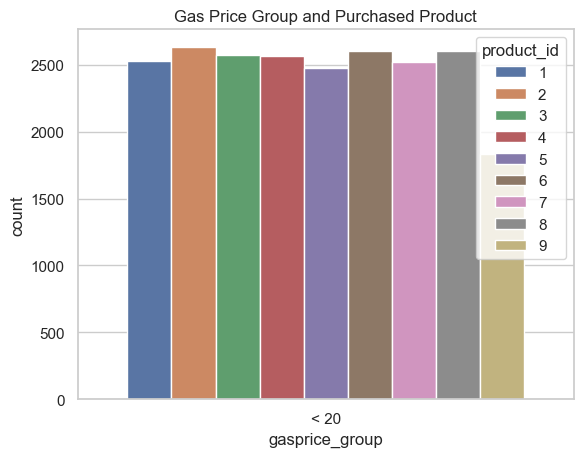

In [37]:
#gas price and product

new_col = 'gasprice_group'
full[new_col] = ''
for index, row in full.iterrows():
    r = row['gas_price_purchase'] 
    if r < 20:
        full.at[index, new_col] = '< 20'
    elif r < 40:
        full.at[index, new_col] = '< 40'
    elif r < 60:
        full.at[index, new_col] = '< 60'
    else:
        full.at[index, new_col] = '>= 60'   

sns.set_theme(style="whitegrid")
sns.countplot(x=full['gasprice_group'], data=full, hue='product_id')
plt.title('Gas Price Group and Purchased Product')
plt.show()

# if dont buy gas -> likely to dont buy redbull

In [38]:
new_col = 'category'
full[new_col] = ''
for index, row in full.iterrows():
    r = row['product_cat'] 
    if r == 0:
        full.at[index, new_col] = 'Beverage'
   
    else:
        full.at[index, new_col] = 'Pastry'   

In [39]:
def plot_categorical_variable(data, name, figsize=(8,4), rotation=45):
    plt.figure(figsize=figsize)
    sns.set_theme(style="whitegrid")
    sns.countplot(x=data[name], data=data, hue='category')
    # plt.title(name)
    plt.xticks(rotation=rotation)
    plt.show()

    plt.figure(figsize=figsize)
    sns.set_theme(style="whitegrid")
    sns.countplot(x=data[name], data=data)
    # plt.title(name)
    plt.xticks(rotation=rotation)
    plt.show()

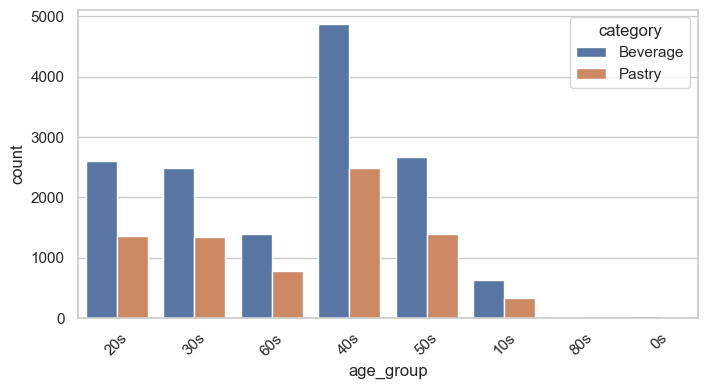

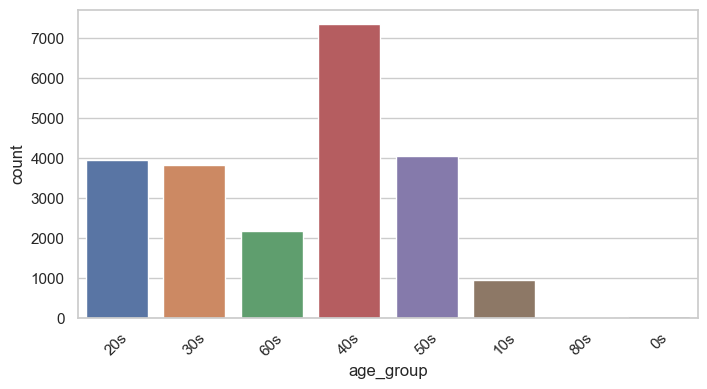

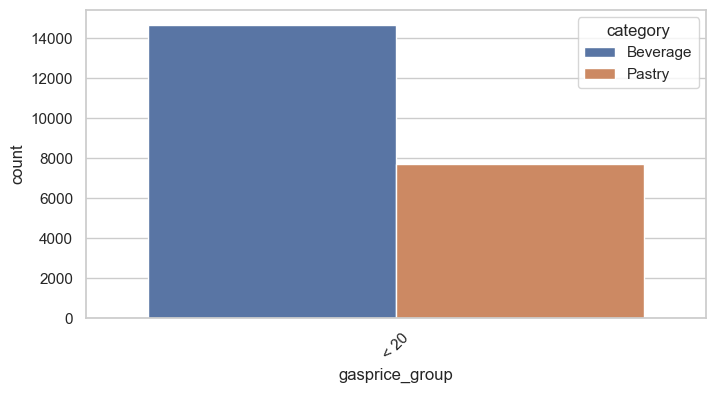

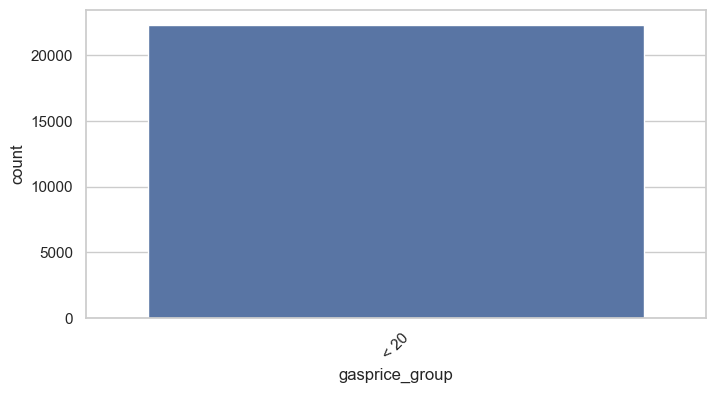

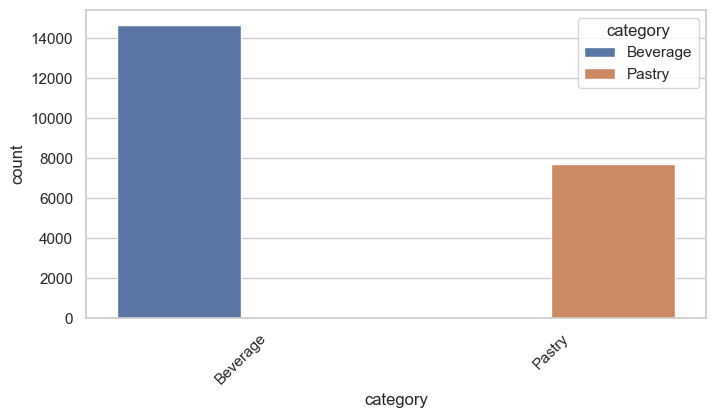

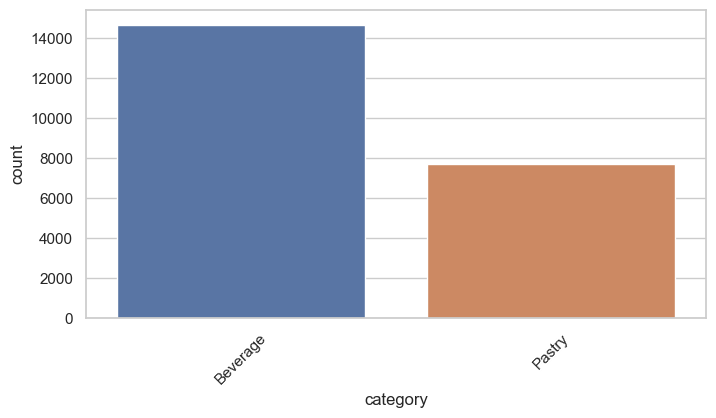

In [40]:
# data visualization for categorical columns

categorical = full.select_dtypes(include=['object']).columns.values

for col in categorical:
    plot_categorical_variable(full, col)

In [41]:
# drop the columns we built to plot the histogram

full.drop(['age_group', 'gasprice_group', 'category'], axis=1, inplace=True)

<AxesSubplot: >

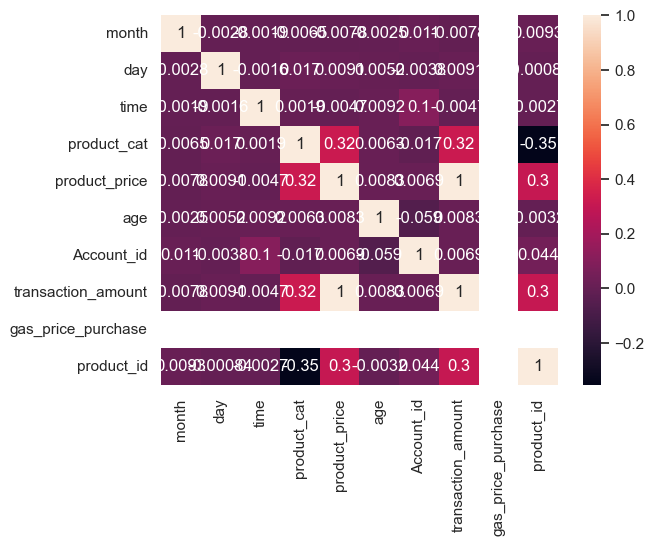

In [42]:
correlation_matrix = full.corr()
sns.heatmap(correlation_matrix, annot =True)

In [43]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_4496\102845399.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


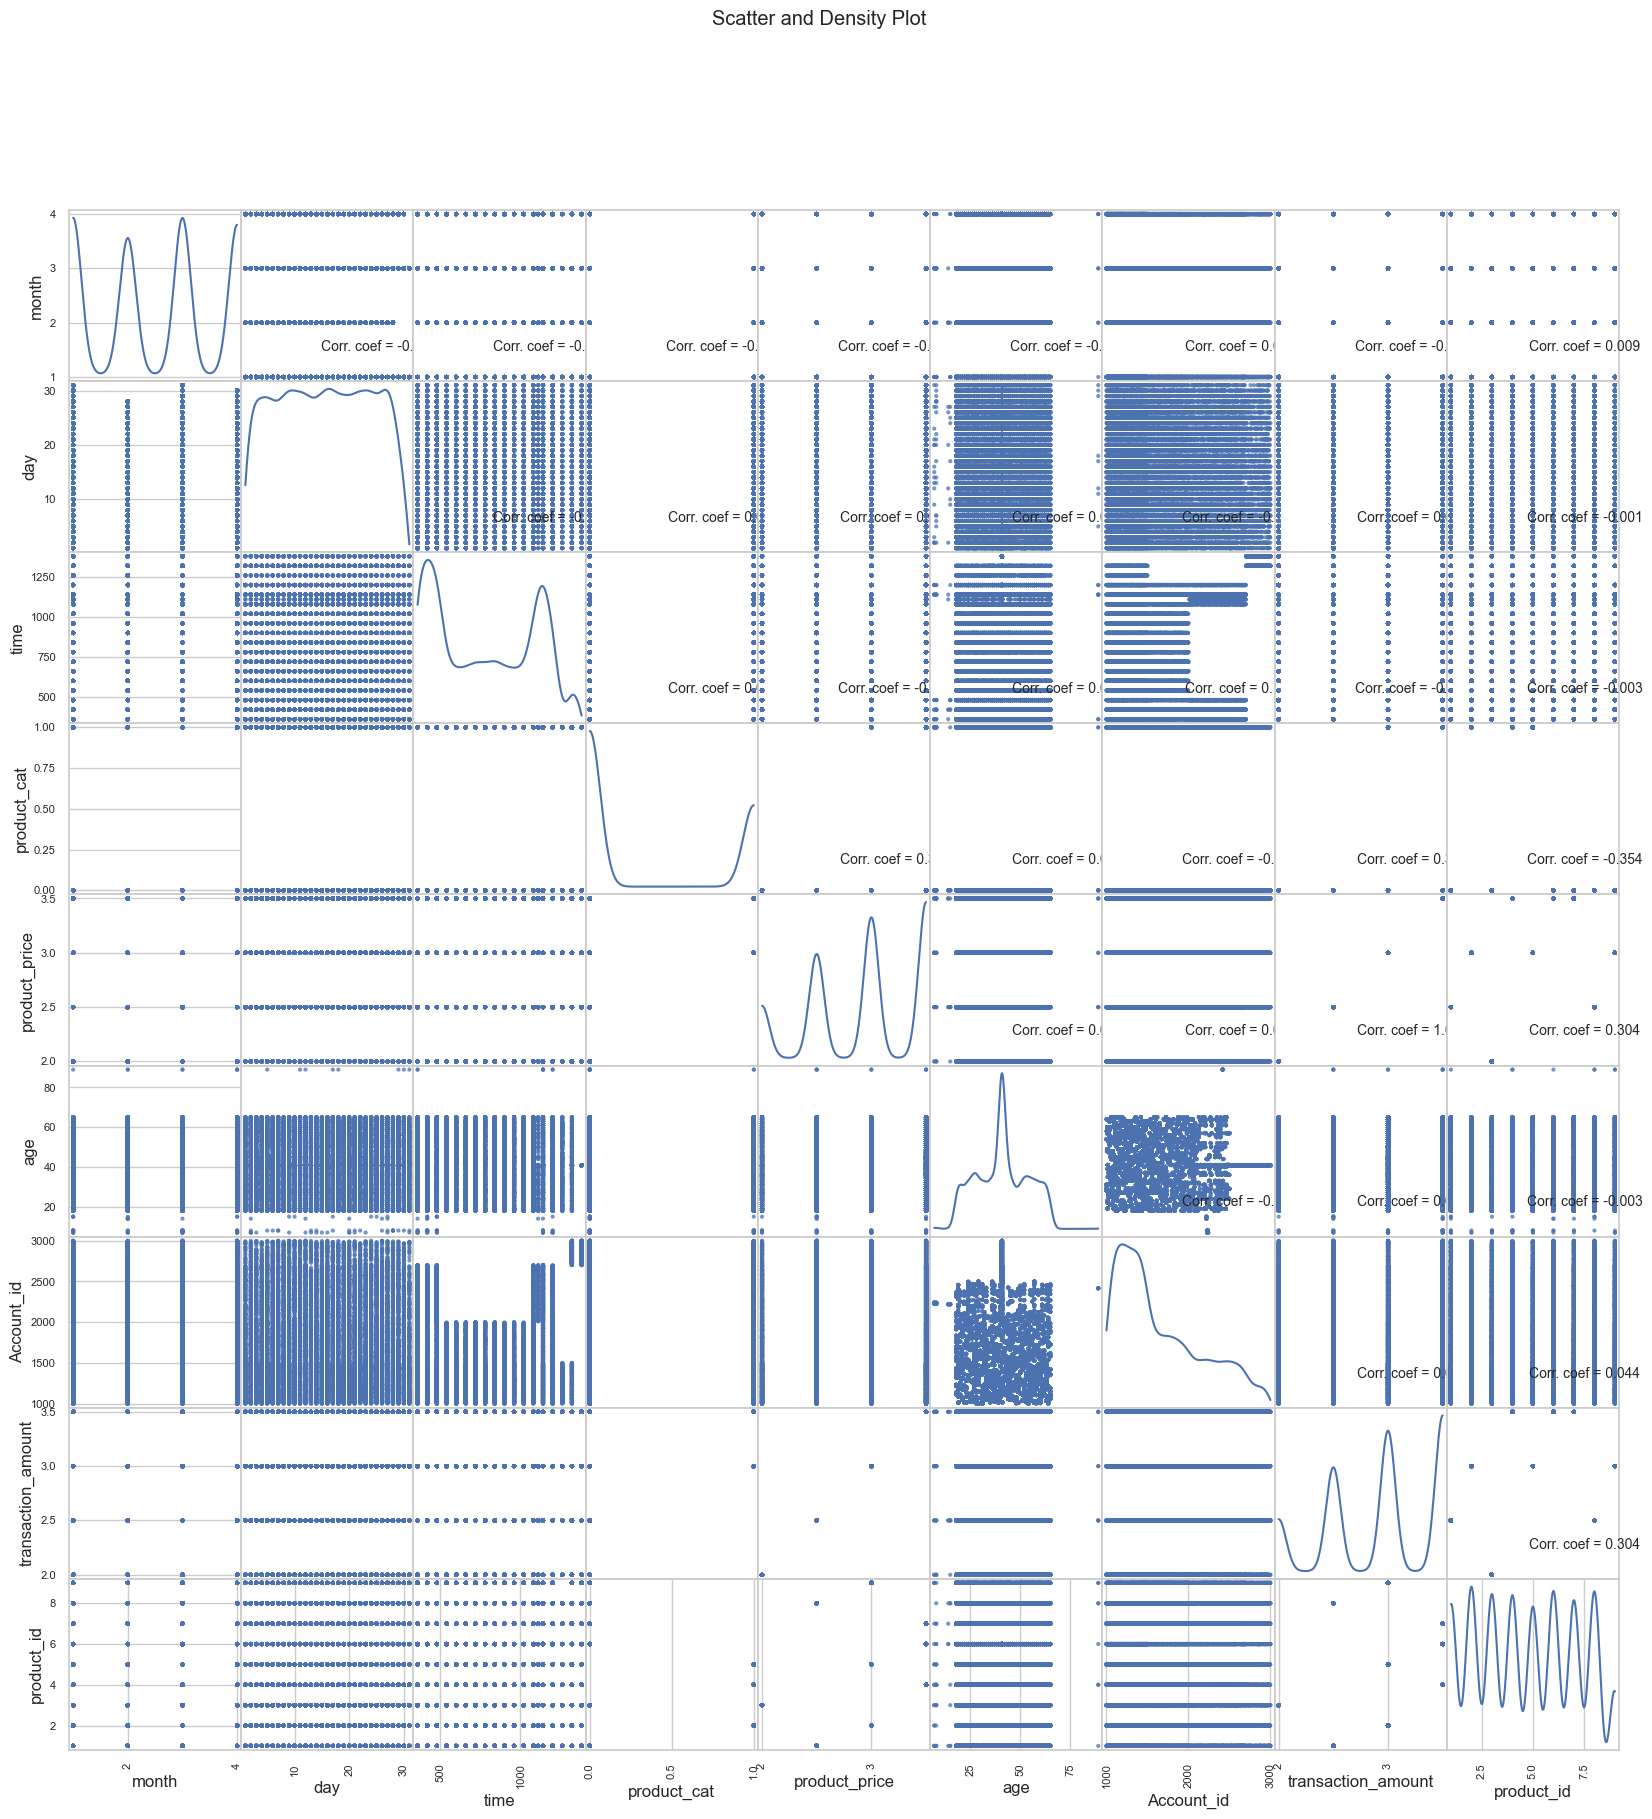

In [44]:
plotScatterMatrix(full, 20, 10)

In [45]:
def vif_scores(df):
    VIF_Scores = pd.DataFrame()
    VIF_Scores["Independent Features"] = df.columns
    VIF_Scores["VIF Scores"] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
    return VIF_Scores
df1 = full.iloc[:,:-1]
vif_scores(df1)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,Independent Features,VIF Scores
0,month,5.487750
1,day,4.050932
2,time,7.017772
3,product_cat,1.666340
4,product_price,inf
5,age,9.681270
6,Account_id,9.594798
7,transaction_amount,inf
8,gas_price_purchase,NaN


**Many of the colums in the data are highly multi-collinear**

**Fortunately, we will be using non-linear classification models which do not have problems with multi-collinearlity**

**However, since the gas_price_purchase dataset is extremely unbalance ie. most people are not paying at all and is highly multi-collineared with other variables, We decide to drop it**

In [46]:
full.drop(['transaction_amount','product_cat', 'product_price'], axis=1, inplace=True)

In [47]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22345 entries, 0 to 44497
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   month               22345 non-null  int64  
 1   day                 22345 non-null  int64  
 2   time                22345 non-null  int64  
 3   age                 22345 non-null  float64
 4   Account_id          22345 non-null  int64  
 5   gas_price_purchase  22345 non-null  float64
 6   product_id          22345 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 1.9 MB


In [48]:
df1 = full.iloc[:,:-1]
vif_scores(df1)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,Independent Features,VIF Scores
0,month,5.100710
1,day,3.848591
2,time,6.531318
3,age,7.773922
4,Account_id,8.070323
5,gas_price_purchase,NaN


# ML

In [49]:
train, test = train_test_split(full,train_size=0.8,test_size=0.2)
train.info()
print()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17876 entries, 235 to 13165
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   month               17876 non-null  int64  
 1   day                 17876 non-null  int64  
 2   time                17876 non-null  int64  
 3   age                 17876 non-null  float64
 4   Account_id          17876 non-null  int64  
 5   gas_price_purchase  17876 non-null  float64
 6   product_id          17876 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 1.1 MB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4469 entries, 23804 to 27199
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   month               4469 non-null   int64  
 1   day                 4469 non-null   int64  
 2   time                4469 non-null   int64  
 3   age                 4469 non-null   f

In [50]:
train

,month,day,time,age,Account_id,gas_price_purchase,product_id
235,1,1,960,38.0,1863,0.0,5
36486,4,9,1140,54.0,1477,0.0,7
35743,4,7,900,36.0,1401,0.0,2
12020,2,2,600,36.0,1072,0.0,1
427,1,2,720,62.0,1184,0.0,7
...,...,...,...,...,...,...,...
15234,2,10,480,19.0,2408,0.0,9
24157,3,7,660,18.0,1363,0.0,9
8771,1,24,420,27.0,1632,0.0,2
26184,3,12,360,52.0,2395,0.0,7


In [51]:
test

,month,day,time,age,Account_id,gas_price_purchase,product_id
23804,3,6,900,18.0,1349,0.0,6
29704,3,22,420,20.0,1195,0.0,2
818,1,3,540,63.0,1232,0.0,4
35992,4,8,360,28.0,1085,0.0,2
28773,3,19,1110,27.0,2201,0.0,4
...,...,...,...,...,...,...,...
13416,2,5,420,57.0,2490,0.0,8
23449,3,5,600,31.0,1389,0.0,5
23167,3,4,720,41.0,1798,0.0,1
7722,1,21,540,35.0,1909,0.0,1


In [52]:
cols = ['month', 'day','time', 'age', 'Account_id', 'gas_price_purchase']

X_train = pd.DataFrame(train[cols])
X_test = pd.DataFrame(test[cols])

Y_train = train['product_id']
Y_test = test['product_id']


X_train.columns = cols
X_test.columns = cols

In [53]:
X_train

,month,day,time,age,Account_id,gas_price_purchase
235,1,1,960,38.0,1863,0.0
36486,4,9,1140,54.0,1477,0.0
35743,4,7,900,36.0,1401,0.0
12020,2,2,600,36.0,1072,0.0
427,1,2,720,62.0,1184,0.0
...,...,...,...,...,...,...
15234,2,10,480,19.0,2408,0.0
24157,3,7,660,18.0,1363,0.0
8771,1,24,420,27.0,1632,0.0
26184,3,12,360,52.0,2395,0.0


In [54]:
X_test

,month,day,time,age,Account_id,gas_price_purchase
23804,3,6,900,18.0,1349,0.0
29704,3,22,420,20.0,1195,0.0
818,1,3,540,63.0,1232,0.0
35992,4,8,360,28.0,1085,0.0
28773,3,19,1110,27.0,2201,0.0
...,...,...,...,...,...,...
13416,2,5,420,57.0,2490,0.0
23449,3,5,600,31.0,1389,0.0
23167,3,4,720,41.0,1798,0.0
7722,1,21,540,35.0,1909,0.0


In [55]:
Y_train

235      5
36486    7
35743    2
12020    1
427      7
        ..
15234    9
24157    9
8771     2
26184    7
13165    5
Name: product_id, Length: 17876, dtype: int64

In [56]:
Y_test

23804    6
29704    2
818      4
35992    2
28773    4
        ..
13416    8
23449    5
23167    1
7722     1
27199    9
Name: product_id, Length: 4469, dtype: int64

In [57]:
# catboost
import catboost
model_cb = catboost.CatBoostClassifier(logging_level='Silent')
model_cb.fit(X_train, Y_train)

Y_catboost = model_cb.predict(X_test)

metrics.accuracy_score(Y_test, Y_catboost)

0.12016110986797941

In [58]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(learning_rate=0.05, max_depth=20, num_leaves=2**15)
lgbm.fit(X_train, Y_train)
y_lgbm = lgbm.predict(X_test)

In [59]:
metrics.accuracy_score(Y_test, y_lgbm)

0.1190422913403446

# Evaluating

In [60]:
col_names = list(test.columns)
col_names

['month',
 'day',
 'time',
 'age',
 'Account_id',
 'gas_price_purchase',
 'product_id']

In [61]:
importance_table = pd.DataFrame({'Features':col_names[:-1:], 'Importances':model_cb.feature_importances_})
display(importance_table)

,Features,Importances
0,month,18.204110
1,day,20.900385
2,time,19.724432
3,age,18.909972
4,Account_id,22.261100
5,gas_price_purchase,0.000000


In [62]:
# train a new model this time using the testing set, we scale the iterations down to 200
model_cb_test = catboost.CatBoostClassifier(learning_rate=0.005, l2_leaf_reg=1, logging_level='Silent', depth=6)
model_cb_test.fit(X_test, Y_test)

In [63]:
importance_table = pd.DataFrame({'Features':col_names[:-1:], 'Importances': model_cb_test.feature_importances_})
importance_table

,Features,Importances
0,month,19.948501
1,day,19.842033
2,time,19.216610
3,age,19.026347
4,Account_id,21.966510
5,gas_price_purchase,0.000000


# Non ML methods

**It is possible that the ML method may not be the best way to recommend**

In [64]:
full_copy

,month,day,time,product_cat,product_price,age,transaction_id,Account_id,transaction_amount,transaction_date,time_to_purchase,gas_type,gas_price_purchase,product_id,Location
0,1,1,1140,0,2.5,28.000000,23,1004,2.50,1/1/2023,19:00,NaN,0.00,1,7
1,1,1,660,0,3.5,49.000000,41666,1013,65.77,1/1/2023,11:00,A,65.77,7,7
2,1,1,720,0,4.0,19.000000,6321,1014,37.80,1/1/2023,12:00,B,37.80,10,7
3,1,1,900,1,3.0,39.000000,34042,1015,3.00,1/1/2023,15:00,NaN,0.00,2,7
4,1,1,960,1,3.0,23.000000,1006,1016,3.00,1/1/2023,16:00,NaN,0.00,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44495,4,30,1320,0,3.5,40.861617,30788,2933,3.50,4/30/2023,22:00,NaN,0.00,6,7
44496,4,30,1380,0,4.0,40.861617,32274,2936,61.02,4/30/2023,23:00,A,61.02,10,7
44497,4,30,1320,1,3.5,40.861617,30444,2957,3.50,4/30/2023,22:00,NaN,0.00,4,7
44498,4,30,1320,0,4.0,40.861617,32399,2978,32.69,4/30/2023,22:00,B,32.69,10,7


In [65]:
full_copy['product_id'].value_counts()

10    16087
2      3447
8      3348
3      3336
1      3317
6      3309
4      3299
7      3296
5      3225
9      1836
Name: product_id, dtype: int64

**1. Previously Ordered**

idea: people are likely to be buying things that they had already purchase before

In [66]:
def get_history(id):
    return full_copy.loc[full_copy['Account_id'] == id]

def get_value_count(id):
    return get_history(id)['product_id'].value_counts()

def get_top(id, n=3, threshold = 3, threshold_ratio = 0, get_all=False):
    product_history = get_history(id)
    tot = len(product_history)
    v = product_history['product_id'].value_counts()
    v_count = len(v)
    if get_all:
        threshold=0
        threshold_ratio=0
        n = v_count
    l = list(v.items())
    ans = []
    for i in range(min(n, v_count)):
        if l[i][1] >= threshold and l[i][1]/tot >= threshold_ratio:
            ans.append(l[i][0])
    return ans, tot

# get top function can be used to get the top n purchased product ID and the total number of transaction,
# which has the occurence beyond threshold and ratio over threshold_ratio
# for example: let us find the top 3 of an ID 1004 witrh different parameters
print(get_top(1004))
print(get_top(1004, get_all=True))

([10, 4, 3], 40)
([10, 4, 3, 7, 5, 1, 6, 9, 2, 8], 40)


In [67]:
#  now let us find the fraction of which the top most purchased item makes up all the purchased item by ID
def get_top_fraction(id):
    product_history = get_history(id)
    tot = len(product_history)
    v = product_history['product_id'].value_counts()
    d = list(v.to_dict().items())
    return d[0][1]/tot

# find average top fraction

top_frac_dict = []
acc_id_list = list(full_copy['Account_id'].value_counts().to_dict().items())

for i,v in acc_id_list:
    top_frac_dict.append(get_top_fraction(i))

print(sum(top_frac_dict)/len(top_frac_dict))

0.43544672465959355


The number 0.4354467 is the ratio of the most frequently purchased item by an ID over the number of their transaction.

This means that if we just recommend the most frequently purchased item by the user, it has the tendency to be correct of 43.5% averagely, so recommending a few ranks from teh list should be sufficiently useful

**2. Top picks at the time**

Idea: There maybe times where certain products are booming in popularity due to some unforseen factors, but once that happens the sales of those product should increase.

The idea of this algorithm is to catch the wave and hope that the factor that influence the others would also influence this customer

In [68]:
# let us make an algorithm in which we can get a few products which is extremely popular in the recent n days

def filter_day(day, month):
    return full_copy.loc[full_copy['day'] == day].loc[full_copy['month'] == month]

def popular_day(day, month):
    return filter_day(day,month)['product_id'].value_counts().to_dict()

jan = [(i,1) for i in range(1,32)]
feb28 = [(i,2) for i in range(1,29)]
feb29 = [(i,2) for i in range(1,30)]
mar = [(i,3) for i in range(1,32)]
apr = [(i,4) for i in range(1,31)]
may = [(i,5) for i in range(1,32)]
jun = [(i,6) for i in range(1,31)]
jul = [(i,7) for i in range(1,32)]
aug = [(i,8) for i in range(1,32)]
sep = [(i,9) for i in range(1,31)]
octo = [(i,10) for i in range(1,32)]
nov = [(i,11) for i in range(1,31)]
dec = [(i,12) for i in range(1,32)]

def get_calendar(year):
    if year%4==0:
        return jan+feb29+mar+apr+may+jun+jul+aug+sep+octo+nov+dec
    return jan+feb28+mar+apr+may+jun+jul+aug+sep+octo+nov+dec

def get_day_index(date):
    month, day, year = [int(i) for i in date.split('/')]
    calendar = get_calendar(year)
    for i in range(len(calendar)):
        if calendar[i][0] == day and calendar[i][1] == month:
            return i

def filter_n_days(n, date, top=10):
    month, day, year = [int(i) for i in date.split('/')]
    calendar = get_calendar(year)
    index = get_day_index(date)
    l = [calendar[index-i] for i in range(n)][::-1]
    ans = {'1':0, '2':0, '3':0, '4':0, '5':0, '6':0, '7':0, '8':0, '9':0, '10':0}
    for d,m in l:
        # print(popular_day(d,m))
        for k,v in popular_day(d,m).items():
            ans[str(k)]+=v
    ordered = sorted(ans.items(), key=lambda item: item[1], reverse=True)
    return ordered[:top]


filter_n_days(5,'4/30/2023')

[('10', 663),
 ('2', 164),
 ('4', 153),
 ('7', 150),
 ('8', 140),
 ('1', 139),
 ('5', 138),
 ('6', 134),
 ('3', 133),
 ('9', 68)]

In [69]:
popular_day(1,4)

{10: 129, 3: 42, 4: 33, 7: 31, 6: 28, 2: 25, 8: 24, 5: 23, 1: 20, 9: 12}